In [4]:
import numpy as np
import pandas as pd
import librosa
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
y,sr =librosa.load( '../datasets/balad/balad1.wav')

In [6]:
print(y)
print(len(y))
print(y.shape)
print('sampling rate (Hz) : %d' %sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

[-1.3038516e-08 -1.8626451e-09 -9.3132257e-09 ... -1.2571148e-02
 -1.9675642e-02 -1.5013282e-02]
705184
(705184,)
sampling rate (Hz) : 22050
Audio length (seconds): 31.98


In [7]:
import IPython.display as ipd
ipd.Audio(y, rate=sr)

- 음악 그래프 <hr>

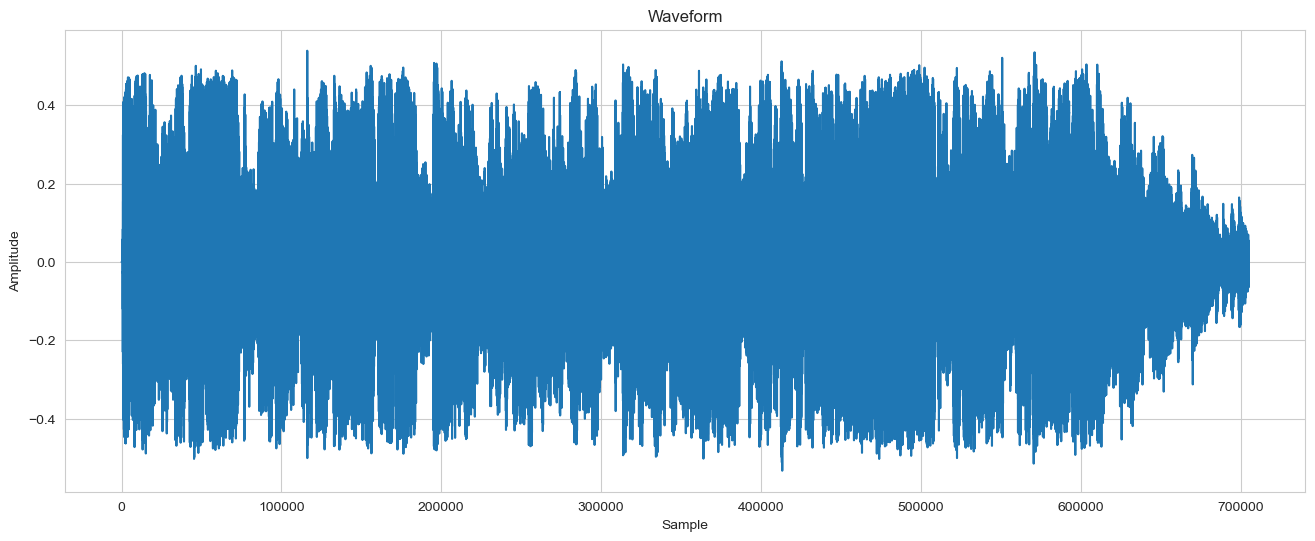

In [8]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize =(16,6))
plt.plot(y)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Fourier Transform (푸리에 변환)
: 시간 영역 데이터를 주파수 영역으로 변경
time(시간) domain -> frequency (진동수)
- y축 : 주파수(로그 스케일)
-color축 : 데시벨(진폭)

(1025, 1378)


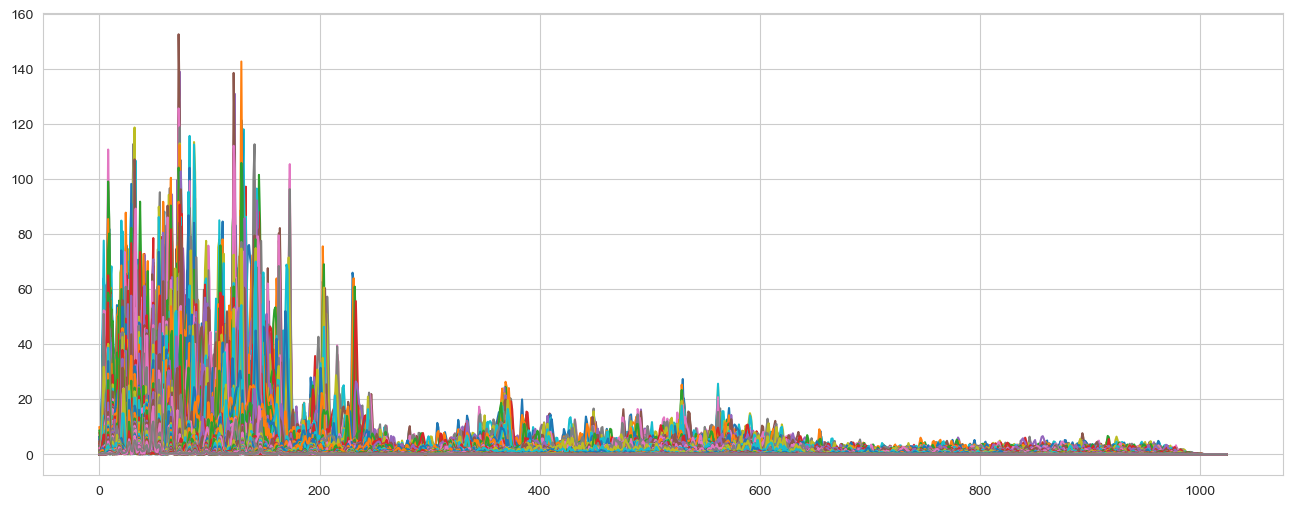

In [9]:
import numpy as np

# n_fft : window size
# 음성의 길이를 얼마만큼으로 자를 것인가? => window
Fourier = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) 

print(Fourier.shape)

plt.figure(figsize=(16,6))
plt.plot(Fourier)
plt.show()


Spectogram : 시간에 따른 신호 주파수의 스펙트럼 그래프

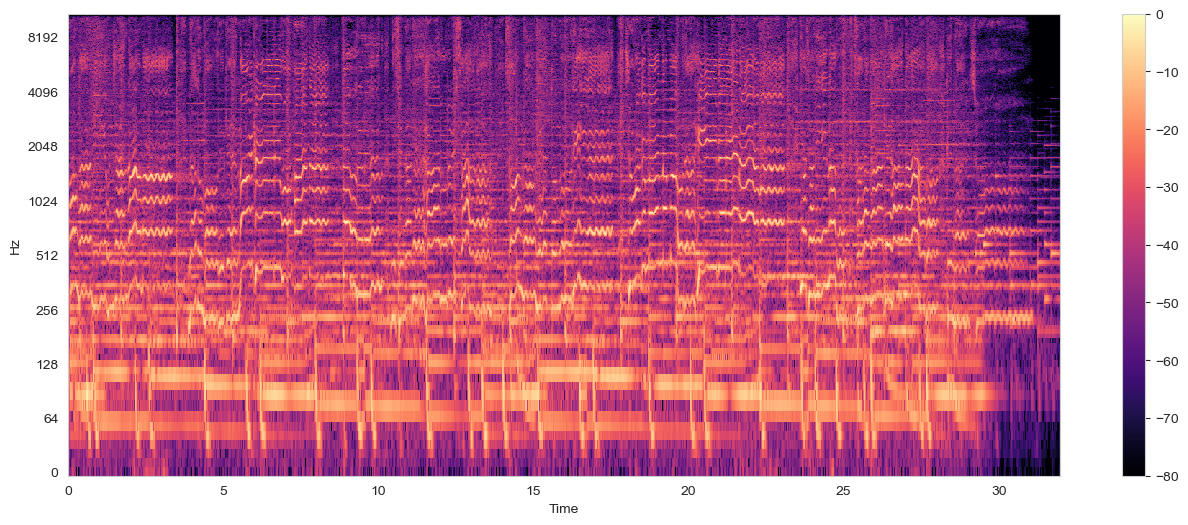

In [10]:
# amplitude(진폭) -> DB(데시벨)로 바꿔라
DB = librosa.amplitude_to_db(Fourier, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(DB,sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

- Mel Spectogram : Spectogram의 y축을 Mel Scale로 변환한 것

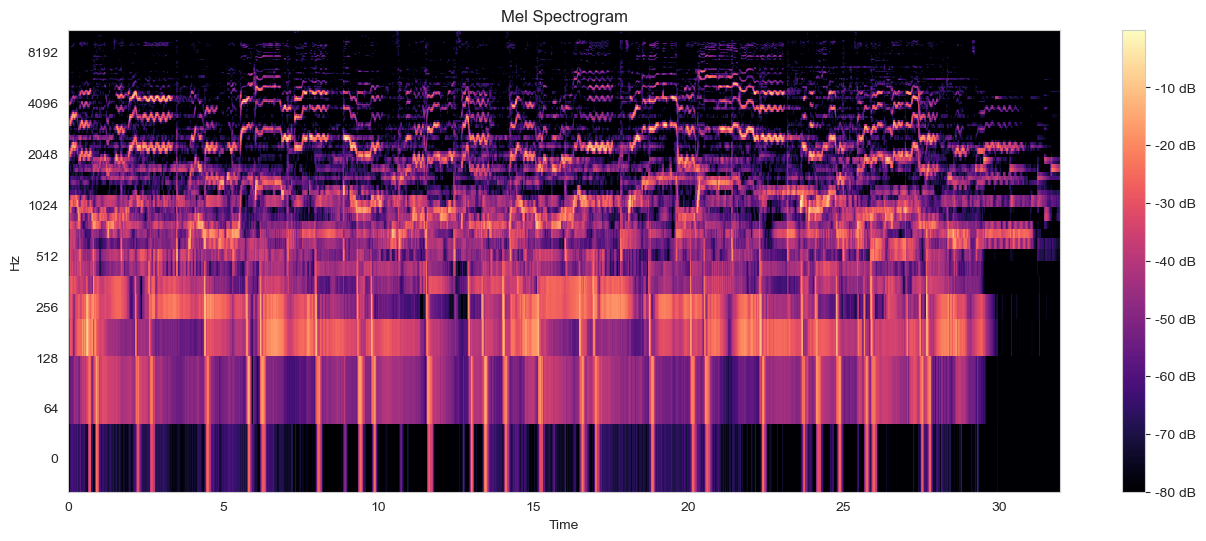

In [11]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

Mel = librosa.feature.melspectrogram(y=y, sr=sr)
Mel_DB = librosa.amplitude_to_db(Mel, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(Mel_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


- Jazz와 HipHop 비교

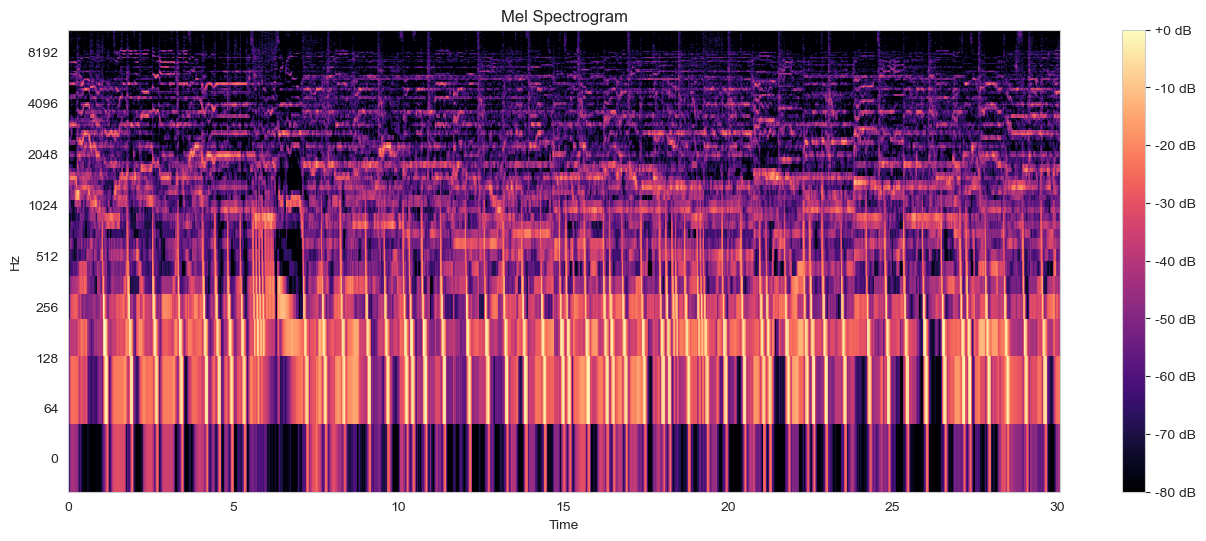

In [12]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로 지정
file_path = '../datasets/dance/dance1.wav'

# 오디오 파일 로드 및 잘라내기
y, sr = librosa.load(file_path)
y, _ = librosa.effects.trim(y)

# Mel 스펙트로그램 계산
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

# 스펙트로그램 시각화
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


- 오디오 특성 추출
- Tempo(BPM)

In [13]:
tempo , _ = librosa.beat.beat_track(y=y,sr=sr)     
print(tempo)

78.30255681818181


- Zero Crossing Rate 
: 음파가 양에서 음으로 또는 음에서 양으로 바뀌는 비율

In [14]:
# 0이 되는 선을 지나친 횟수
zero_crossings = librosa.zero_crossings(y, pad=False)

print(zero_crossings)
print(sum(zero_crossings)) # 음 <-> 양 이동한 횟수

[False False False ... False False False]
91203


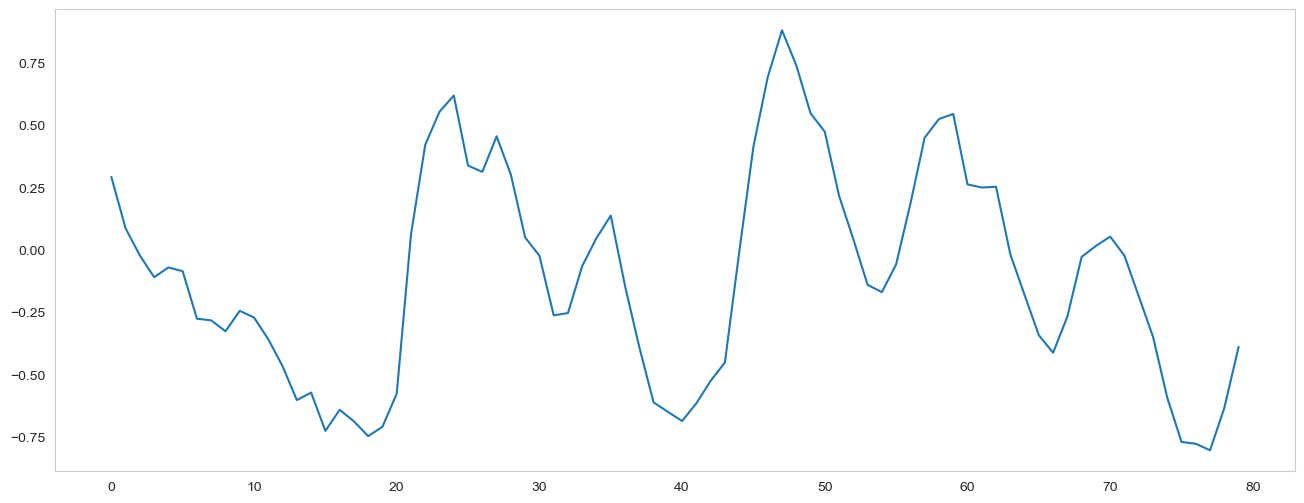

In [15]:
n0 = 9000
n1 = 9080

plt.figure(figsize=(16,6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()

In [16]:
 #n0 ~ n1 사이 zero crossings 
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

11


- 특징 추출
- Harmonic and Percussive Components
- Precussives : 리듬과 감정을 나타내는 충격파
- Harmonics : 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)

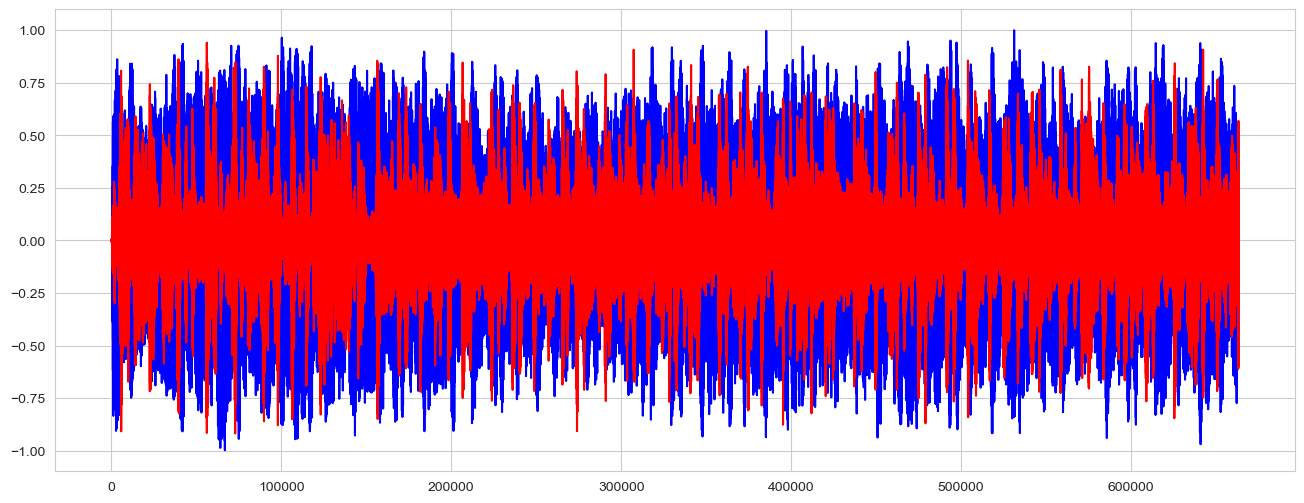

In [17]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16,6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

Special Centroid
: 소리를 주파수로 표현했을 때, 주파수의 가중평균을 계산하여 소리의 "무게중심"이 어딘지 알려주는 지표

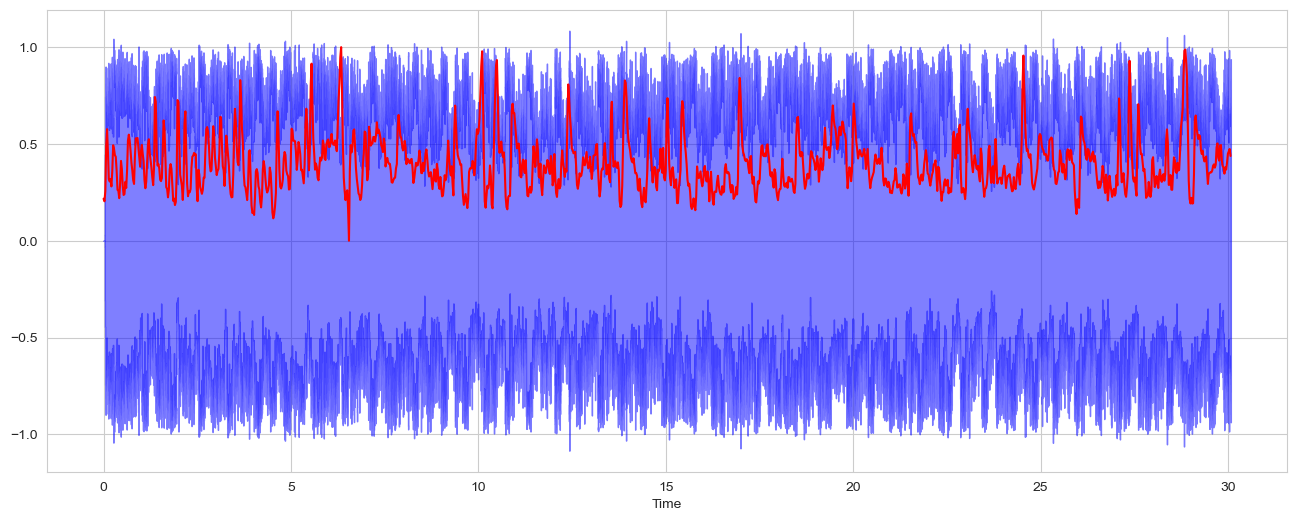

In [18]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

#Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
# sk.minmax_scale() : 최대 최소를 0 ~ 1 로 맞춰준다.
  return sklearn.preprocessing.minmax_scale(x, axis=axis) 

plt.figure(figsize=(16,6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()


Spectral Rolloff
- 총 스펙트럼 에너지 중 낮은 주파수(85%이하)에 얼마나 많이 집중되어 있는가
- 신호 모양을 측정

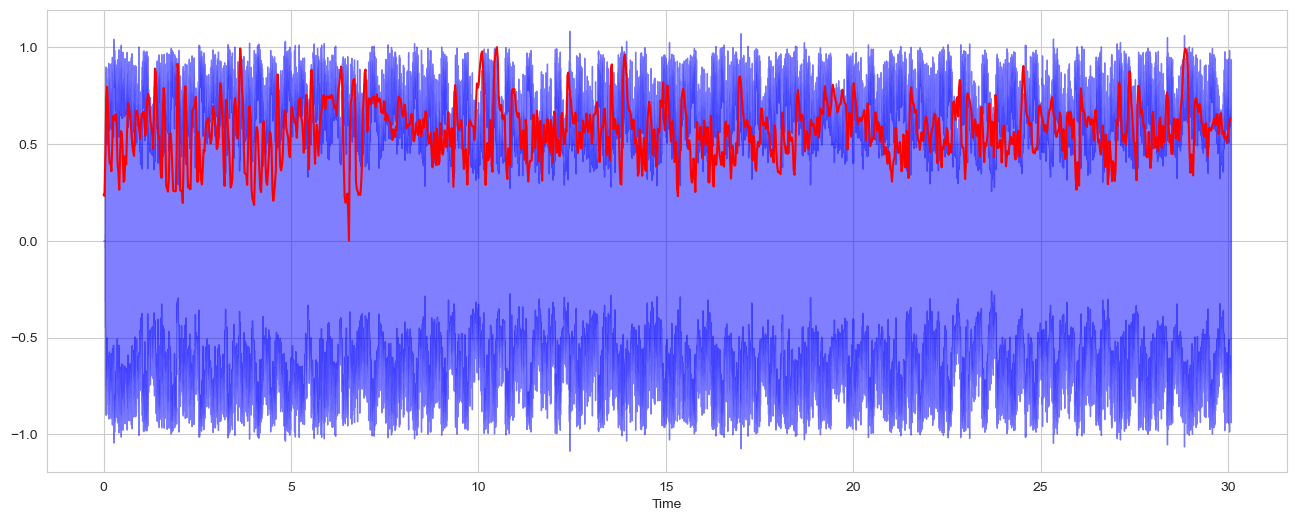

In [19]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

plt.figure(figsize=(16,6))
librosa.display.waveshow(y,sr=sr,alpha=0.5,color='b')
plt.plot(t, normalize(spectral_rolloff),color='r')
plt.show()

Mel-Frequency Cepstral Coefficients(MFCCs)
- 특징들의 작은 집합으로 스펙트럴 포곡선의 전체적인 모양을 축약
- 사람의 청각 구조를 반영하여 음성 정보 추출
- 1. 전체 오디오 신호를 일정 간격으로 나누고 푸리에 변환을 거쳐 스펙트로그램을 구함
- 2. 각 스펙트럼의 제곱인 파워 스펙트로그램에 Mel scale filter bank를 사용해 차원 수 줄임
- 3. cepstral 분석을 적용해 MFCC 구함

mean : 0.49
var : 0.03


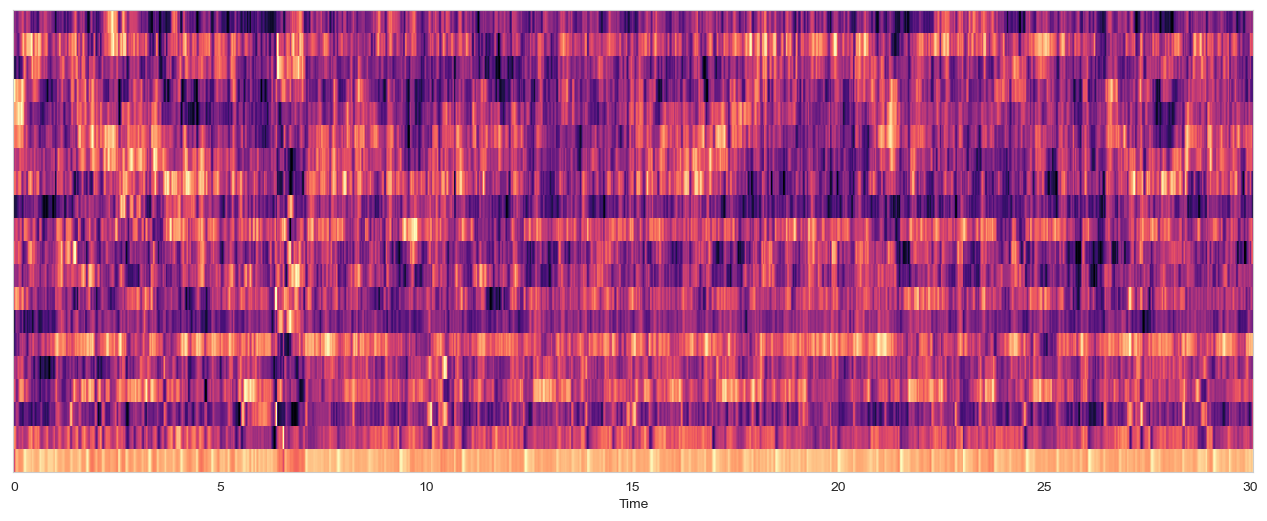

In [20]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
mfccs = normalize(mfccs,axis=1)

print('mean : %.2f' % mfccs.mean())
print('var : %.2f' % mfccs.var())

plt.figure(figsize=(16,6))
librosa.display.specshow(mfccs,sr=sr, x_axis='time')
plt.show()

Chroma Frequencies
- 크로마는 인간 청각이 옥타브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지
- 크로마 특징은 음악의 흥미롭고 강렬한 표현

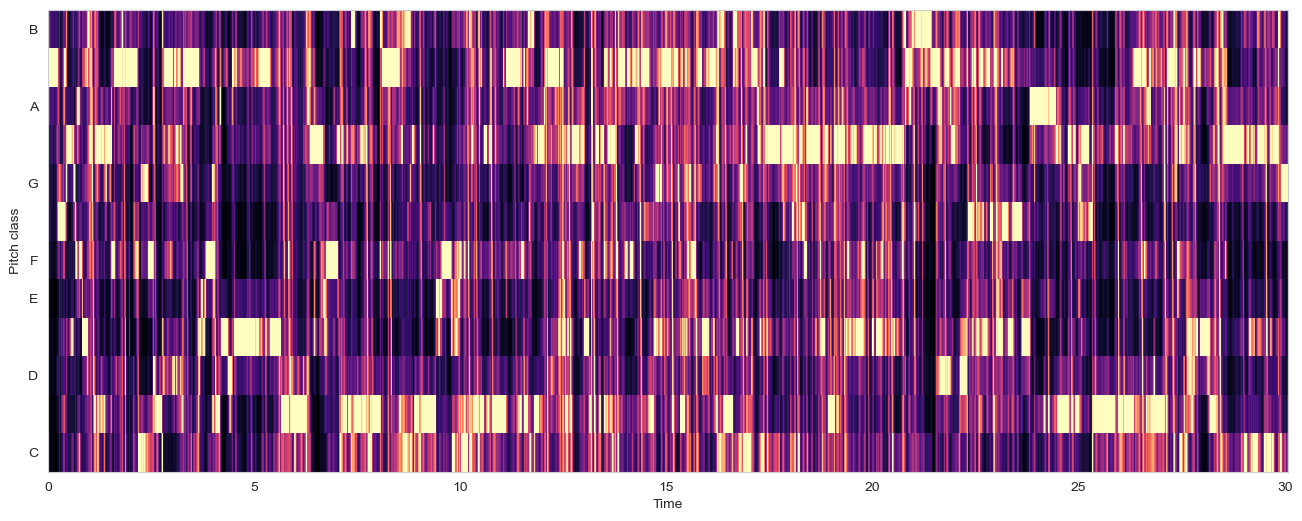

In [21]:
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)

plt.figure(figsize=(16,6))
librosa.display.specshow(chromagram,x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

음악 장르 분류
- 1) 데이터셋 로드

In [24]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')  # 그래프 테두리 모두 제거

In [25]:
import pandas as pd
import librosa
import numpy as np
import os

# WAV 파일이 있는 디렉토리 경로
wav_dir = '../datasets/balad/'

# 모든 WAV 파일 리스트
wav_files = [f for f in os.listdir(wav_dir) if f.endswith('.wav')]

# DataFrame을 저장할 빈 리스트 생성
df_list = []

# 각 WAV 파일에 대해 특징 계산 및 DataFrame에 추가
for wav_file in wav_files:
    # WAV 파일 로드
    y, sr = librosa.load(os.path.join(wav_dir, wav_file))
    
    # MFCCs 계산
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = normalize(mfccs, axis=1)
    
    # Spectral Centroids 계산
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    
    # Spectral Rolloff 계산
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    
    # Chromagram 계산
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    
    # 각 특징들의 평균과 분산 계산
    data = {
        'Filename': wav_file,
        'MFCC_Mean': [np.mean(mfccs)],
        'MFCC_Var': [np.var(mfccs)],
        'Chromagram_Mean': [np.mean(chromagram)],
        'Chromagram_Var': [np.var(chromagram)],
        'Spectral_Centroids_Mean': [np.mean(spectral_centroids)],
        'Spectral_Centroids_Var': [np.var(spectral_centroids)],
        'Spectral_Rolloff_Mean': [np.mean(spectral_rolloff)],
        'Spectral_Rolloff_Var': [np.var(spectral_rolloff)]
    }
    
    # 데이터를 DataFrame으로 변환하여 리스트에 추가
    df_list.append(pd.DataFrame(data))

# 모든 DataFrame을 하나의 큰 DataFrame으로 결합
combined_df = pd.concat(df_list, ignore_index=True)

# CSV 파일로 저장
output_csv = '../datasets/balad.csv'
combined_df.to_csv(output_csv, index=False)

print(f'CSV 파일이 저장되었습니다: {output_csv}')


CSV 파일이 저장되었습니다: ../datasets/balad.csv


In [26]:
df = pd.read_csv('../datasets/balad.csv')

In [28]:
import pandas as pd
import librosa
import numpy as np
import os

# WAV 파일이 있는 디렉토리 경로
wav_dir = '../datasets/dance/'

# 모든 WAV 파일 리스트
wav_files = [f for f in os.listdir(wav_dir) if f.endswith('.wav')]

# DataFrame을 저장할 빈 리스트 생성
df_list = []

# 각 WAV 파일에 대해 특징 계산 및 DataFrame에 추가
for wav_file in wav_files:
    # WAV 파일 로드
    y, sr = librosa.load(os.path.join(wav_dir, wav_file))
    
    # MFCCs 계산
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = normalize(mfccs, axis=1)
    
    # Spectral Centroids 계산
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    
    # Spectral Rolloff 계산
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    
    # Chromagram 계산
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    
    # 각 특징들의 평균과 분산 계산
    data = {
        'Filename': wav_file,
        'MFCC_Mean': [np.mean(mfccs)],
        'MFCC_Var': [np.var(mfccs)],
        'Chromagram_Mean': [np.mean(chromagram)],
        'Chromagram_Var': [np.var(chromagram)],
        'Spectral_Centroids_Mean': [np.mean(spectral_centroids)],
        'Spectral_Centroids_Var': [np.var(spectral_centroids)],
        'Spectral_Rolloff_Mean': [np.mean(spectral_rolloff)],
        'Spectral_Rolloff_Var': [np.var(spectral_rolloff)]
    }
    
    # 데이터를 DataFrame으로 변환하여 리스트에 추가
    df_list.append(pd.DataFrame(data))

# 모든 DataFrame을 하나의 큰 DataFrame으로 결합
combined_df = pd.concat(df_list, ignore_index=True)

# CSV 파일로 저장
output_csv = '../datasets/dance.csv'
combined_df.to_csv(output_csv, index=False)

print(f'CSV 파일이 저장되었습니다: {output_csv}')

KeyboardInterrupt: 

In [29]:
df1=pd.read_csv('../datasets/dance.csv')
df1

Filename  MFCC_Mean  MFCC_Var  Chromagram_Mean  Chromagram_Var  \
0     dance1.wav   0.489988  0.033041         0.400657        0.078549   
1    dance10.wav   0.511985  0.026403         0.323609        0.089227   
2   dance100.wav   0.552881  0.031364         0.395786        0.085953   
3    dance11.wav   0.456371  0.028548         0.419955        0.091638   
4    dance12.wav   0.520097  0.027969         0.404513        0.095733   
..           ...        ...       ...              ...             ...   
95   dance95.wav   0.536010  0.028652         0.452296        0.073915   
96   dance96.wav   0.512686  0.033420         0.461052        0.079091   
97   dance97.wav   0.514403  0.033896         0.453968        0.082924   
98   dance98.wav   0.506988  0.028863         0.355894        0.086442   
99   dance99.wav   0.487209  0.029890         0.426902        0.082017   

    Spectral_Centroids_Mean  Spectral_Centroids_Var  Spectral_Rolloff_Mean  \
0               3031.744451           262402.111776            6690.902880   
1               3521.691436           615706.295625            7611.610131   
2               2075.578894           273000.713072            4477.564591   
3               2994.065949           657715.812247            6632.300854   
4               2883.383618           985023.482894            6382.657424   
..                      ...                     ...                    ...   
95              3709.006631           317237.063188            7536.587761   
96              2846.767239           212712.898368            6155.412779   
97              2856.282555           222344.821060            6070.879957   
98              2850.517661           364587.168174            6487.485771   
99              2686.535149           186158.045297            6140.312870   

    Spectral_Rolloff_Var  
0           8.629812e+05  
1           1.425984e+06  
2           1.708391e+06  
3           2.357550e+06  
4           2.998763e+06  
..                   ...  
95          7.425829e+05  
96          9.570356e+05  
97          1.092423e+06  
98          1.358243e+06  
99          9.217041e+05  

[100 rows x 9 columns]

csv 파일 합치기

In [30]:
# 두 DataFrame을 결합
combined_df = pd.concat([df, df1], ignore_index=True)

# 결합된 DataFrame을 CSV 파일로 저장
output_csv = '../datasets/kpop.csv'
combined_df.to_csv(output_csv, index=False)

print(f'두 개의 CSV 파일이 성공적으로 합쳐졌습니다: {output_csv}')

두 개의 CSV 파일이 성공적으로 합쳐졌습니다: ../datasets/kpop.csv


In [31]:
kpopDF = pd.read_csv('../datasets/kpop.csv')
kpopDF

Filename  MFCC_Mean  MFCC_Var  Chromagram_Mean  Chromagram_Var  \
0      balad1.wav   0.492151  0.030902         0.270474        0.089341   
1     balad10.wav   0.494340  0.029432         0.297158        0.089418   
2    balad100.wav   0.494599  0.033184         0.269402        0.092836   
3     balad11.wav   0.522101  0.035166         0.312291        0.089319   
4     balad12.wav   0.503501  0.031803         0.329324        0.090454   
..            ...        ...       ...              ...             ...   
195   dance95.wav   0.536010  0.028652         0.452296        0.073915   
196   dance96.wav   0.512686  0.033420         0.461052        0.079091   
197   dance97.wav   0.514403  0.033896         0.453968        0.082924   
198   dance98.wav   0.506988  0.028863         0.355894        0.086442   
199   dance99.wav   0.487209  0.029890         0.426902        0.082017   

     Spectral_Centroids_Mean  Spectral_Centroids_Var  Spectral_Rolloff_Mean  \
0                2387.264407           346469.319717            5625.463371   
1                2760.713355           874983.475055            6078.346578   
2                2282.748033           741578.172628            5864.322873   
3                2553.538250           614269.047823            5838.439696   
4                2637.886078           398300.408776            5882.086706   
..                       ...                     ...                    ...   
195              3709.006631           317237.063188            7536.587761   
196              2846.767239           212712.898368            6155.412779   
197              2856.282555           222344.821060            6070.879957   
198              2850.517661           364587.168174            6487.485771   
199              2686.535149           186158.045297            6140.312870   

     Spectral_Rolloff_Var  
0            1.714409e+06  
1            2.545436e+06  
2            4.915561e+06  
3            1.723735e+06  
4            1.513782e+06  
..                    ...  
195          7.425829e+05  
196          9.570356e+05  
197          1.092423e+06  
198          1.358243e+06  
199          9.217041e+05  

[200 rows x 9 columns]

In [32]:
kpopDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Filename                 200 non-null    object 
 1   MFCC_Mean                200 non-null    float64
 2   MFCC_Var                 200 non-null    float64
 3   Chromagram_Mean          200 non-null    float64
 4   Chromagram_Var           200 non-null    float64
 5   Spectral_Centroids_Mean  200 non-null    float64
 6   Spectral_Centroids_Var   200 non-null    float64
 7   Spectral_Rolloff_Mean    200 non-null    float64
 8   Spectral_Rolloff_Var     200 non-null    float64
dtypes: float64(8), object(1)
memory usage: 14.2+ KB


- balad1~balad100 => balad로 이름 변경
- dance1~dance100 => dance로 이름 변경

In [46]:
# 인덱스를 사용하여 행의 이름 변경
kpopDF.index = ['balad' + str(i) for i in range(1, 101)] + ['dance' + str(i) for i in range(1, 101)]

# 새로운 열 추가 및 라벨 할당
kpopDF['Label'] = kpopDF.index.to_series().apply(lambda x: 0 if str(x).startswith('balad') else 1)

In [53]:
kpopDF=kpopDF.drop('Filename',axis=1)

In [54]:
kpopDF.info()


<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, balad1 to dance100
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MFCC_Mean                200 non-null    float64
 1   MFCC_Var                 200 non-null    float64
 2   Chromagram_Mean          200 non-null    float64
 3   Chromagram_Var           200 non-null    float64
 4   Spectral_Centroids_Mean  200 non-null    float64
 5   Spectral_Centroids_Var   200 non-null    float64
 6   Spectral_Rolloff_Mean    200 non-null    float64
 7   Spectral_Rolloff_Var     200 non-null    float64
 8   Label                    200 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 23.7+ KB


feature와 target 분리

In [55]:
targetDF = kpopDF['Label']
featureDF = kpopDF.drop(columns=['Label'])
print('featureDF',featureDF)
print('targetDF',targetDF)

featureDF           MFCC_Mean  MFCC_Var  Chromagram_Mean  Chromagram_Var  \
balad1     0.492151  0.030902         0.270474        0.089341   
balad2     0.494340  0.029432         0.297158        0.089418   
balad3     0.494599  0.033184         0.269402        0.092836   
balad4     0.522101  0.035166         0.312291        0.089319   
balad5     0.503501  0.031803         0.329324        0.090454   
...             ...       ...              ...             ...   
dance96    0.536010  0.028652         0.452296        0.073915   
dance97    0.512686  0.033420         0.461052        0.079091   
dance98    0.514403  0.033896         0.453968        0.082924   
dance99    0.506988  0.028863         0.355894        0.086442   
dance100   0.487209  0.029890         0.426902        0.082017   

          Spectral_Centroids_Mean  Spectral_Centroids_Var  \
balad1                2387.264407           346469.319717   
balad2                2760.713355           874983.475055   
balad3        

- Train / Test 분할

In [56]:
X_train , X_test , y_train, y_test = train_test_split(featureDF,targetDF,test_size=0.2,random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(160, 8) (160,)
(40, 8) (40,)


    - 모델 구축

Logistic Regression

In [57]:
# Logistic Regression 모델 생성
LRmodel = LogisticRegression()

# 모델 훈련
LRmodel.fit(X_train, y_train)

# 테스트 데이터로 예측
predictions = LRmodel.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8


RandomForest

In [58]:
# Random Forest 모델 생성
RFmodel = RandomForestClassifier()

# 모델 훈련
RFmodel.fit(X_train, y_train)

# 테스트 데이터로 예측
predictions = RFmodel.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.875


Decision Tree

In [59]:
# Decision Tree 모델 생성
DTmodel = DecisionTreeClassifier()

# 모델 훈련
DTmodel.fit(X_train, y_train)

# 테스트 데이터로 예측
predictions = DTmodel.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.875


In [60]:
# 정밀도 계산
precision = precision_score(y_test, predictions)

# 재현율 계산
recall = recall_score(y_test, predictions)

# F1 점수 계산
f1 = f1_score(y_test, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9375
Recall: 0.7894736842105263
F1 Score: 0.8571428571428572


In [61]:
import pickle
# 모델 저장
with open('../datasets/RFmodel.pkl','wb') as f:
    pickle.dump(RFmodel, f)